# Plot Kmeans clusters stored in a GeoTiff

This is a notebook plots the GeoTiffs created out of [kmeans](../stable/kmeans.ipynb). Such GeoTiffs contains the Kmeans cluster IDs.

## Dependencies

In [1]:
import sys
sys.path.append("/usr/lib/spark/python")
sys.path.append("/usr/lib/spark/python/lib/py4j-0.10.4-src.zip")
sys.path.append("/usr/lib/python3/dist-packages")

import os
os.environ["HADOOP_CONF_DIR"] = "/etc/hadoop/conf"

import os
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["PYSPARK_DRIVER_PYTHON"] = "ipython"

from pyspark.mllib.clustering import KMeans, KMeansModel 
from pyspark import SparkConf, SparkContext

from osgeo import gdal
from io import BytesIO

import matplotlib.pyplot as plt
import rasterio
from rasterio import plot
from rasterio.io import MemoryFile

## Spark Context

In [2]:
appName = "plot_kmeans_clusters"
masterURL="spark://emma0.phenovari-utwente.surf-hosted.nl:7077"

try:
    sc.stop()
except NameError:
    print("A  new Spark Context will be created.")
    
sc = SparkContext(conf = SparkConf().setAppName(appName).setMaster(masterURL))

A  new Spark Context will be created.


## Mode of Operation setup

The user should modify the following variables to define which GeoTiffs should be loaded. In case it (s)he wants to visualize results that just came out of [kmeans](kmeans.ipnyb) laste execution, just copy the values set at its [**Mode of Operation Setup**](../stable/kmeans.ipynb#mode_of_operation_setup).

In [3]:
#GeoTiffs to be read from "hdfs:///user/hadoop/spring-index/"
dir_path = "hdfs:///user/hadoop/spring-index/"
offline_dir_path = "hdfs:///user/emma/spring-index/"
geoTiff_dir = "BloomFinal00s"

#Kmeans number of iterations and clusters
numIterations = 35
minClusters = 12
maxClusters = 12
stepClusters = 1

## Mode of Operation verification

In [4]:
geotiff_hdfs_paths = []

if minClusters > maxClusters:
    maxClusters = minClusters
    stepClusters = 1

if stepClusters < 1:
    stepClusters = 1
    
numClusters_id = 0
numClusters = minClusters
while numClusters <= maxClusters :
    path = offline_dir_path + geoTiff_dir + '/clusters_' + str(numClusters) + '_' + str(numIterations) + '.tif'
    geotiff_hdfs_paths.append(path)
    numClusters_id += 1
    numClusters += stepClusters

## Load GeoTiffs

Load the GeoTiffs into MemoryFiles.

In [5]:
clusters_dataByteArrays = []

numClusters_id = 0
numClusters = minClusters
while numClusters <= maxClusters :
    clusters_data = sc.binaryFiles(geotiff_hdfs_paths[numClusters_id]).take(1)
    clusters_dataByteArrays.append(bytearray(clusters_data[0][1]))
    numClusters_id += 1
    numClusters += stepClusters

## Check GeoTiffs metadata

In [6]:
for val in clusters_dataByteArrays:
    #Create a Memory File
    memFile = MemoryFile(val).open()
    print(memFile.profile)
    memFile.close()

{'count': 1, 'tiled': False, 'compress': 'deflate', 'height': 3892, 'crs': CRS({'init': 'epsg:4326'}), 'dtype': 'float64', 'interleave': 'band', 'driver': 'GTiff', 'nodata': nan, 'width': 7808, 'transform': Affine(0.008983152841195215, 0.0, -126.30312894720473,
       0.0, -0.008983152841195215, 49.25462702827337)}


## Plot GeoTiffs

Plot for 12 clusters!!!


<IPython.core.display.Javascript object>


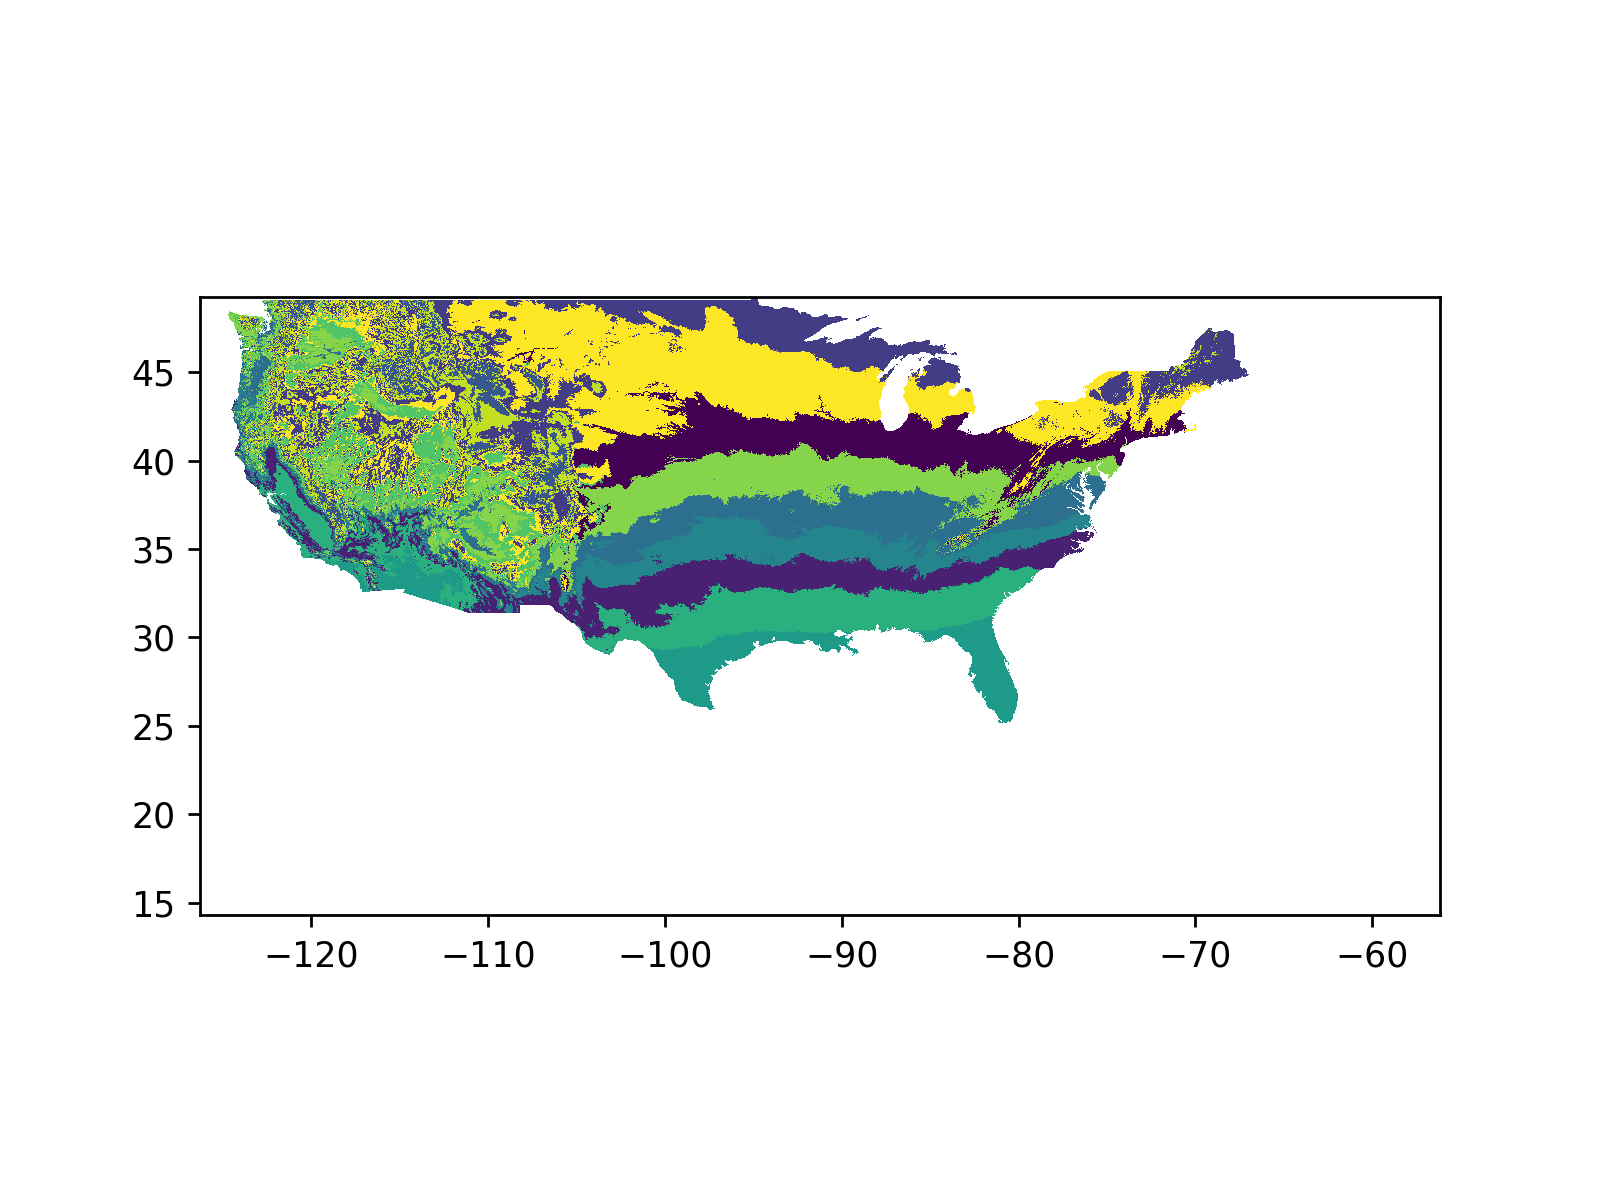

In [7]:
%matplotlib notebook

numClusters_id = 0
numClusters = minClusters
while numClusters <= maxClusters :
    print ("Plot for " + str(numClusters) + " clusters!!!")
    memFile = MemoryFile(clusters_dataByteArrays[numClusters_id]).open()
    plot.show((memFile,1))
    if (numClusters < maxClusters) :
        _ = input("Press [enter] to continue.")
    memFile.close()
    numClusters_id += 1
    numClusters += stepClusters
